# Set working dir

In [2]:
import os 
import warnings
import platform

warnings.filterwarnings("ignore")
if "macOS" in platform.platform():
    os.chdir("/Users/erjo3868/repos/hypedsearch/hypedsearch")
# Running on Fiji
else:
    os.chdir("/scratch/Shares/layer/hypedsearch/hypedsearch")


# Index protein-product ion DB

In [15]:
%%time
from src.lookups.protein_product_ion_db import load_existing_protein_product_ion_db
import os
db_path = "dbs/Uniprot_mouse.fasta_max_k=30_charges=(1, 2, 3).db"
size_gb = os.path.getsize(db_path) / (1024 ** 3)
print(f"DB size BEFORE indexing = {size_gb}")

db = load_existing_protein_product_ion_db(db_path=db_path)
db.create_index_on_product_ion_mass()

size_gb = os.path.getsize(db_path) / (1024 ** 3)
print(f"DB size AFTER indexing = {size_gb}")

ModuleNotFoundError: No module named 'src.lookups'

# Create protein-product ion DBs

In [16]:
import pandas as pd
from src.erik import load_comet_data
from src.constants import PRODUCT_ION_TABLE
from src.fasta_utils import get_proteins_from_fasta, get_specific_protein_from_fasta
from src.lookups.protein_product_ion_db import create_protein_product_ion_db, get_average_mass_search_time
from experiments.ions_per_mass import main

fasta_path = "fastas/Uniprot_mouse.fasta"
db_path = "dbs/test.proteinproduction.db"

ModuleNotFoundError: No module named 'src.erik'

In [ ]:
fasta_proteins = list(get_proteins_from_fasta(fasta_path=fasta_path))
fasta_proteins = fasta_proteins[:10]

# protein_name = "sp|P99027|RLA2_MOUSE"
# protein = get_specific_protein_from_fasta(fasta_path=fasta_path, protein_name=protein_name)
db = create_protein_product_ion_db(
    db_path=db_path,
    protein_seqs=[protein.sequence for protein in fasta_proteins[:10]],
    charges_to_consider=[1, 2],
    max_kmer_len=30,
)

In [ ]:
df = main(db_path=db_path, sample_size=10, ppm_tolerance=10, output_dir=None)
df

Generating random sample...
Finished generating random sample
Ion 1 of 10
Ion 2 of 10
Ion 3 of 10
Ion 4 of 10
Ion 5 of 10
Ion 6 of 10
Ion 7 of 10
Ion 8 of 10
Ion 9 of 10
Ion 10 of 10


,mass,time,num_matching_ions,len_search_ion,num_matching_ions_by_charge
0,2527.323138,0.823784,24,23,{1: 24}
1,982.411230,0.417797,8,8,"{1: 7, 2: 1}"
2,1631.340411,0.208170,18,28,{2: 18}
3,3724.859914,0.415554,3,30,{1: 3}
4,1719.840417,0.817771,19,15,"{2: 5, 1: 14}"
5,1868.837106,1.221565,10,16,{1: 10}
6,50.541483,0.819681,310,1,{2: 310}
7,3390.959707,0.807122,2,30,{1: 2}
8,487.248152,1.229158,24,8,"{1: 15, 2: 9}"
9,455.738771,0.832291,11,8,{2: 11}


In [ ]:
db_path = "dbs/Uniprot_mouse.fasta_max_k=30_charges=(1, 2, 3).db"
df = main(db_path=db_path, sample_size=10, ppm_tolerance=10, output_dir=None)

Generating random sample...


# How long does it take to query the protein-product ion DB by mass? 

In [ ]:
from src.lookups.protein_product_ion_db import load_existing_protein_product_ion_db

db_path = "dbs/Uniprot_mouse.fasta_max_k=30_charges=(1, 2, 3).db"
db = load_existing_protein_product_ion_db(db_path=db_path)
# query = f"SELECT {MASS} FROM {PRODUCT_ION_TABLE} ORDER BY RANDOM() LIMIT {sample_size};"
# db.run_query(query=query)

In [ ]:
db.get_charges_in_db()

In [ ]:
df = main(db_path=db_path, sample_size=10, ppm_tolerance=10, output_dir=None)

The above was really slow.
Let's try ChatGPT's suggested way

In [ ]:
from Bio import SeqIO
from src.constants import MOUSE_PROTEOME

fasta_proteins = list(get_proteins_from_fasta(fasta_path=MOUSE_PROTEOME))

def get_unique_kmers(fasta_file, k):
    unique_kmers = set()
    
    # Read FASTA sequences one at a time
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq = str(record.seq)
        
        # Generate kmers using a sliding window
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i + k]
            unique_kmers.add(kmer)  # Sets automatically store only unique kmers
    
    return unique_kmers

uniq_kmers = {}
for k in tqdm(np.arange(1, 31)):
    uniq_kmers[k] = get_unique_kmers(fasta_file=MOUSE_PROTEOME, k=k)



100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


In [ ]:
cum_sum = {}
for k, kmers in uniq_kmers.items():
    k, len(kmers)
    break

(1, 24)

# Compare spectrum to DB

In [ ]:



from dataclasses import dataclass
from src.constants import IonTypes
from src.protein_product_ion_database import ProteinProductIonDb, DbProtein

@dataclass
class MinimalProductIon:
    protein_id: int
    charge: int
    neutral_mass: int
    inclusive_start: int

DbProtein(id=0, seq="ACDE")

DbProtein
min_k, max_k = 2, 2
charges = [1]
ion_types = [IonTypes.B_ION_TYPE]
db = ProteinProductIonDb(
    min_k=min_k,
    max_k=max_k,
    charges=charges,
    ion_types=ion_types,
)

x = DbProtein(id=0, seq="ACDE")
x.make_table_query(db=db)

DbProtein(id=0, seq='ACDE')

src.protein_product_ion_database.DbProtein

AttributeError: 'DbProtein' object has no attribute 'make_table_query'

# Number of total k-mers vs unique k-mers in mouse proteome

In [ ]:
from tqdm import tqdm
from src.peptides_and_ions import Peptide, get_unique_kmers
from src.constants import MOUSE_PROTEOME
import pandas as pd

peptides = Peptide.from_fasta(fasta_path=MOUSE_PROTEOME)

k_vals = list(range(1, 26))
rows = []
for k in tqdm(k_vals):
    num_total_kmers = sum([
        (len(peptide.seq) - k +  1) 
        for peptide in peptides
    ])
    num_uniq_kmers = len(get_unique_kmers(peptides=peptides, k=k))
    rows.append([k, num_total_kmers, num_uniq_kmers])
    df = pd.DataFrame(rows, columns=["k", "total_kmers", "uniq_kmers"])

100%|██████████| 25/25 [11:24<00:00, 27.37s/it]


In [ ]:
from src.plot_utils import fig_setup, finalize, set_

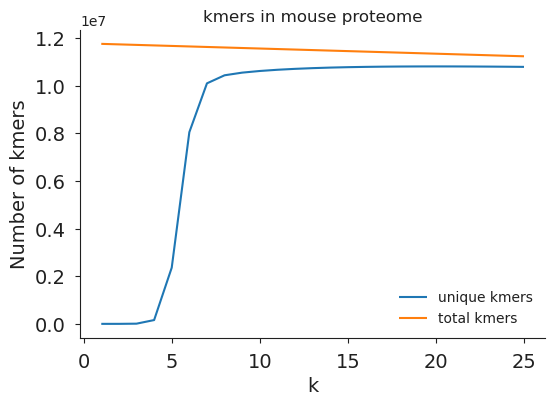

In [ ]:
from src.plot_utils import fig_setup, finalize, set_title_axes_labels

_, axs = fig_setup()
ax = axs[0]

ax.plot(df["k"], df["uniq_kmers"], label="unique kmers")
ax.plot(df["k"], df["total_kmers"], label="total kmers")
set_title_axes_labels(ax=ax, xlabel="k", ylabel="Number of kmers", title="kmers in mouse proteome")
finalize(axs)



# Proteins in mouse proteome vs Comet run 1

In [ ]:
from src.comet_utils import load_comet_data, CometRow
from src.peptides_and_ions import get_proteins_from_fasta
from src.utils import flatten_list_of_lists

comet_df = load_comet_data()
# comet_df.head(2)
comet_rows = CometRow.from_dataframe(comet_df)
all_comet_proteins = flatten_list_of_lists([row.proteins for row in comet_rows])
uniq_comet_proteins = set(all_comet_proteins)
fasta_proteins = get_proteins_from_fasta(fasta_path=MOUSE_PROTEOME)


Reading data for BMEM_AspN_Fxn4
Reading data for BMEM_AspN_Fxn5
Reading data for BMEM_AspN_Fxn6
Reading data for BMEM_AspN_Fxn7
Reading data for BMEM_AspN_Fxn8
Reading data for BMEM_AspN_Fxn9


Number of unique Comet proteins = 16174
Minimum Comet protein abundance = 1, max = 971
Number of proteins in mouse proteome = 21759


,x,number_proteins_gt_x-1_le_x
0,1,4369
1,2,3040


(0.0, 50.0)

,x,number_proteins_gt_x
0,0,16174
1,1,11805


(10.0, 50.0)

(-1.0, 1000.0)

Text(0.5, 0.98, 'Comet run 1 data')

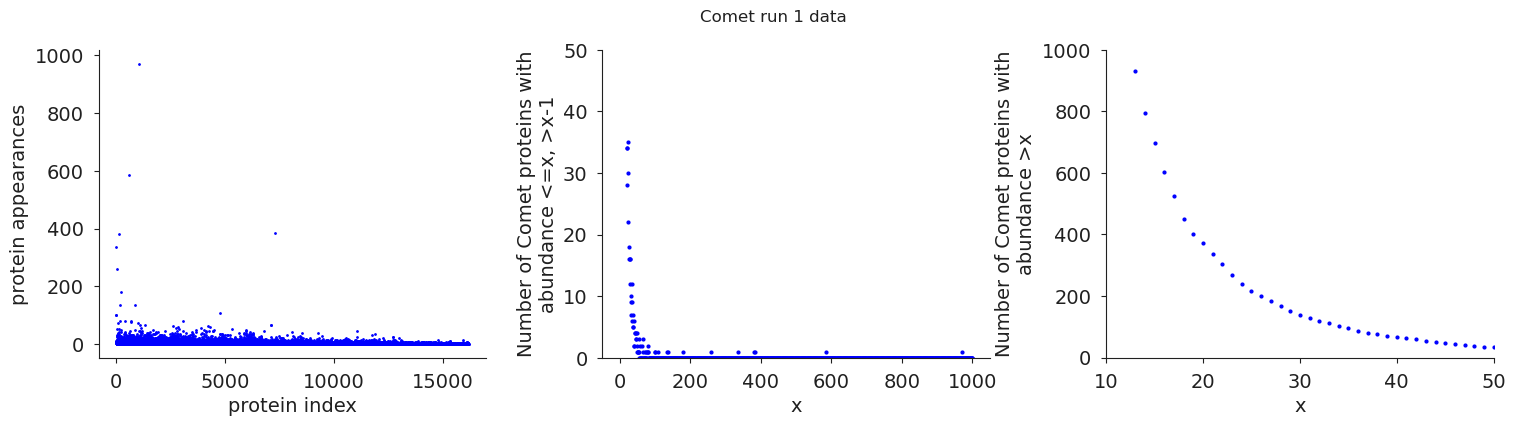

In [ ]:
from typing import Counter
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

print(f"Number of unique Comet proteins = {len(uniq_comet_proteins)}")
assert len(fasta_proteins) == len(set([protein.name for protein in fasta_proteins])), "Why aren't the number of proteins in the fasta the same as the number of unique proteins?"
comet_protein_abundances = np.array(list(Counter(all_comet_proteins).values()))
print(f"Minimum Comet protein abundance = {min(comet_protein_abundances)}, max = {max(comet_protein_abundances)}")
print(f"Number of proteins in mouse proteome = {len(fasta_proteins)}")

_, axs = fig_setup(1, 3)
ax = axs[0]
_=ax.plot(
    comet_protein_abundances,
    "bo",
    ms=1,
)
set_title_axes_labels(
    ax=ax, 
    xlabel="protein index", 
    ylabel="protein appearances",
    # title="Number of times protein appears in Comet run 1 data"
)
finalize(axs)

data = []
prev_val = 0
for val in range(1, 1001):
    data.append([val, sum((comet_protein_abundances>prev_val) & (comet_protein_abundances<=val))])
    # data.append([val, sum((comet_protein_abundances<=val))])
    prev_val = val
colm1, colm2 = "x", "number_proteins_gt_x-1_le_x"
data = pd.DataFrame(data, columns=[colm1, colm2])
data.head(2)

# _, axs = fig_setup()
ax = axs[1]
_=ax.plot(
    data[colm1], data[colm2],
    "bo",
    ms=2
)
set_title_axes_labels(
    ax=ax, 
    xlabel="x", 
    ylabel="Number of Comet proteins with\nabundance <=x, >x-1",
    # title="Number of times protein appears in Comet run 1 data"
)
ax.set_ylim(0, 50)
finalize(axs)

data = []
for val in range(0, 1001):
    data.append([val, sum((comet_protein_abundances>val))])
colm1, colm2 = "x", "number_proteins_gt_x"
data = pd.DataFrame(data, columns=[colm1, colm2])
data.head(2)

# _, axs = fig_setup()
ax = axs[2]
_=ax.plot(
    data[colm1], data[colm2],
    "bo",
    ms=2
)
set_title_axes_labels(
    ax=ax, 
    xlabel="x", 
    ylabel="Number of Comet proteins with\nabundance >x",
    # title="Number of times protein appears in Comet run 1 data"
)
plt.xlim(left=10, right=50)
plt.ylim(top=1000, bottom=-1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle("Comet run 1 data")
finalize(axs)


# Analyze Comet PSMs

In [3]:
from src.comet_utils import CometRow, load_comet_data
from src.constants import IONS_MATCHED, PLAIN_PEPTIDE, PROTEIN, PROTEIN_COUNT, SAMPLE, SCAN
comet_df = load_comet_data()
comet_df.head(2)
comet_rows = CometRow.from_dataframe(comet_df)


Reading data for BMEM_AspN_Fxn4
Reading data for BMEM_AspN_Fxn5
Reading data for BMEM_AspN_Fxn6
Reading data for BMEM_AspN_Fxn7
Reading data for BMEM_AspN_Fxn8
Reading data for BMEM_AspN_Fxn9


,scan,num,charge,exp_neutral_mass,calc_neutral_mass,e-value,xcorr,delta_cn,sp_score,ions_matched,...,plain_peptide,modified_peptide,prev_aa,next_aa,protein,protein_count,modifications,retention_time_sec,sp_rank,sample
0,7,1,3,1525.774133,1525.773636,0.000202,2.187,0.4294,229.0,15,...,SAAPAAGSAPAAAEEKK,G.SAAPAAGSAPAAAEEKK.D,G,D,"tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE,sp|P99027|RLA2_...",2,-,714.0,1,BMEM_AspN_Fxn4
1,7,2,3,1525.774133,1525.773636,2.030000,1.248,0.0200,26.0,6,...,AAQTPGSGEAVLSKNP,T.AAQTPGSGEAVLSKNP.N,T,N,sp|Q8BI84|TGO1_MOUSE,1,-,714.0,16,BMEM_AspN_Fxn4


In [10]:

from src.constants import PLAIN_PEPTIDE, RESULTS_DIR, IonTypes
from src.peptide_spectrum_comparison import PeptideSpectrumComparison, compare_peptide_to_spectrum
from src.peptides_and_ions import Peptide
from src.comet_utils import CometRow
from src.utils import decompress_and_unpickle, pickle_and_compress
from dataclasses import dataclass
from tqdm import tqdm

testing = True
peak_filtering = True
top_n_peaks = 50
ppm_tolerance = 10
ion_types = [IonTypes.B_ION_TYPE, IonTypes.Y_ION_TYPE]

@dataclass
class PSM:
    comet_row: CometRow
    psm: PeptideSpectrumComparison

psms = []
for row_num, row in tqdm(enumerate(comet_rows)):
# for row_num, row in df.iterrows():
    peptide = Peptide(seq=row.proposed_peptide)
    spectrum = row.get_corresponding_spectrum()

    # Peak filtering
    if peak_filtering:
        spectrum.filter_to_top_n_peaks(n=top_n_peaks)
        assert spectrum.peaks_preprocessed

    comparison = compare_peptide_to_spectrum(
        peptide=peptide, 
        spectrum=spectrum, 
        ppm_tolerance=ppm_tolerance,
        ion_types=ion_types
    )
    psms.append(
        PSM(
        comet_row=row,
        psm=comparison)
    )
    if testing:
        if row_num >= 2:
            break

if testing:
    path = RESULTS_DIR / f"TESTING_comet_run_1_psms_ppmTol={ppm_tolerance}_peakFiltering={peak_filtering}_topN={top_n_peaks}.pkl"
else:
    path = RESULTS_DIR / f"comet_run_1_psms_ppmTol={ppm_tolerance}_peakFiltering={peak_filtering}_topN={top_n_peaks}.pkl"
pickle_and_compress(obj=psms, file_path=path)
# decompress_and_unpickle(file_path=path)

2it [00:09,  4.91s/it]


In [5]:
decompress_and_unpickle(file_path=path)

[PSM(comet_row=CometRow(sample='BMEM_AspN_Fxn4', scan=7, ions_matched=15, proteins=['tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE', 'sp|P99027|RLA2_MOUSE'], protein_count=2, proposed_peptide='SAAPAAGSAPAAAEEKK'), psm=PeptideSpectrumComparison(num_peaks=50, num_peaks_with_a_product_ion_match=12, num_product_ions=34, num_product_ions_with_match=10, num_peaks_matching_product_ion={('S', 'b'): 0, ('SA', 'b'): 1, ('SAA', 'b'): 1, ('SAAP', 'b'): 0, ('SAAPA', 'b'): 0, ('SAAPAA', 'b'): 0, ('SAAPAAG', 'b'): 0, ('SAAPAAGS', 'b'): 0, ('SAAPAAGSA', 'b'): 0, ('SAAPAAGSAP', 'b'): 0, ('SAAPAAGSAPA', 'b'): 0, ('SAAPAAGSAPAA', 'b'): 0, ('SAAPAAGSAPAAA', 'b'): 0, ('SAAPAAGSAPAAAE', 'b'): 0, ('SAAPAAGSAPAAAEE', 'b'): 0, ('SAAPAAGSAPAAAEEK', 'b'): 0, ('SAAPAAGSAPAAAEEKK', 'b'): 0, ('SAAPAAGSAPAAAEEKK', 'y'): 1, ('AAPAAGSAPAAAEEKK', 'y'): 1, ('APAAGSAPAAAEEKK', 'y'): 2, ('PAAGSAPAAAEEKK', 'y'): 2, ('AAGSAPAAAEEKK', 'y'): 1, ('AGSAPAAAEEKK', 'y'): 1, ('GSAPAAAEEKK', 'y'): 0, ('SAPAAAEEKK', 'y'): 0, ('APAAAEEKK', 'y'): 1,

# Info about spectra

In [25]:
from src.mass_spectra import load_mzml_data


spectra = load_mzml_data()

Reading sample BMEM_AspN_Fxn4's MZML
Reading sample BMEM_AspN_Fxn5's MZML
Reading sample BMEM_AspN_Fxn6's MZML
Reading sample BMEM_AspN_Fxn7's MZML
Reading sample BMEM_AspN_Fxn8's MZML
Reading sample BMEM_AspN_Fxn9's MZML
